## Housing Prices and Words

The data for this exercise has been scraped from Zillow and contains the price, the number of bedrooms, the number of bathrooms, the square footage, the location, and a description. The objective of this assignment is to use LASSO to understand which words contribute the most to price.

I have done most of the work for you in terms of processing the text. What is left is for you to fit the models at various levels of alpha and interpret the results.

In [72]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np 
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

data_dir = "C:/Users/jhtchns2/Box/ACE 592 SAE - Spring 2023/Class_Examples/4_Analysis/"
df = pd.read_csv(data_dir+'ZillowWebscrap_Champaign.csv')

In [73]:
sw_list = stopwords.words('english') + ['amp',''," "]

vct = CountVectorizer(stop_words=sw_list)
tfidf = TfidfVectorizer(stop_words=sw_list)

X = vct.fit_transform(df['description']).todense()
X = pd.DataFrame(X,columns=["word_" + x for x in vct.get_feature_names_out()])
df = pd.concat([df,X],axis=1) 

X_tfidf = tfidf.fit_transform(df['description']).todense()
X_tfidf = \
pd.DataFrame(X_tfidf,
             columns = ["word_tfidf_" +x for x in tfidf.get_feature_names_out()])
df = pd.concat([df,X_tfidf],axis=1) 

cols = ['beds', 'baths', 'sq_feet','lat','lon'] + list(df.columns[10:])

X = StandardScaler().fit_transform(df[cols])

y = StandardScaler().fit_transform(df[['price']])

def get_coefs(alpha,features,target):
    X = StandardScaler().fit_transform(df[features])
    y = StandardScaler().fit_transform(df[target])
    
    lasso_model =Lasso(alpha=alpha)
    lasso_model = lasso_model.fit(y=y,X=X)
    
    coefs = lasso_model.coef_
    
    return coefs

Alpha = np.arange(0,1,.01)

### My solution:
- Start by looking at what is left after choosing alpha=0.1

In [124]:
model = Lasso(alpha=.1)
model = model.fit(X=X,y=y)
initial_words = list(df[cols].loc[:,model.coef_!=0].columns)

In [125]:
initial_words

['baths',
 'sq_feet',
 'word_complete',
 'word_custom',
 'word_design',
 'word_golf',
 'word_granite',
 'word_half',
 'word_maple',
 'word_professional',
 'word_prospect',
 'word_tfidf_panoramic',
 'word_tfidf_residence',
 'word_tfidf_suites',
 'word_tfidf_sweeping']

- Look at how the coefficients change over different values of alpha.

C:\Users\jhtchns2\AppData\Local\Temp\ipykernel_21632\2598414763.py:27: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model = lasso_model.fit(y=y,X=X)
C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.757e+00, tolerance: 1.610e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_

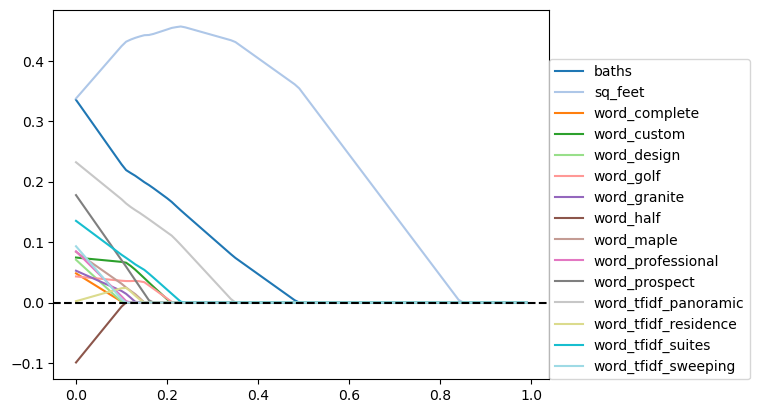

In [127]:
# Get a list of all of the coefficients which are themselves a list for every value of the grid
out = [list(get_coefs(a,initial_words,['price'])) for a in Alpha]

# Make a dataframe because its easier to plot
df_ = pd.DataFrame(out,columns=initial_words,index=Alpha)
                            #  word labels         alpha vals
# Plot it over alpha
df_.plot(cmap="tab20") # this colormap is easier to see
plt.axhline(0,color='black',ls="--") # origin line
plt.legend(loc=(1,0)) # get the legend out of the way

A couple of observations:
- Square feet is by far the best predictor of price. It's influence grows after all the other words are zeroed out, which seems to tell us that the other words are simply proxying for square footage.
- Bathrooms is the second most important. Recall that in class other people had bedrooms but I did not. this is because LASSO will through out things that are correlated (in this case bedrooms can probably predict square footage well).
- The word "panaromic" is the important word. Notice that only the TFIDF version came up because it isnt used very often.
- Other common words: 
    - granite and maple, probably indicating renovations.
    - "golf" probably is proxying for the country club in Champaign
    - "prospect" is probably Prospect Ave, which is a place where expensive homes are.
    - The only negative coef is "half," probably because homes with half bathrooms cost less.
    
 
 
__Which alpha gives us the best prediction?__

In [128]:
# Fitting the LassoCV model with 10-fold cross validation
lasso_model = LassoCV(alphas=Alpha,cv=10)

# Fit the data
lasso_model = lasso_model.fit(X=X,y=y)

C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\jhtchns2\.conda\envs\test\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged

To find the "best" alpha, access this parameter:

In [132]:
lasso_model.alpha_

0.03

Which means it kept a lot of words:

In [133]:
final_words = list(df[cols].loc[:,lasso_model.coef_!=0].columns)

In [135]:
len(final_words)

185

Which were the most important?

Alot of them are very small, let's just look at ones that were more than .015 in either direction:

In [160]:
final_coefs = pd.DataFrame([cols,lasso_model.coef_]).T

final_coefs = final_coefs.set_index(0)

final_coefs = final_coefs[final_coefs[1]!=0]

import numpy as np
final_coefs["abs_"] = np.abs(final_coefs[1])

In [161]:
final_coefs[final_coefs['abs_']>.015]

,1,abs_
0,,
baths,0.252075,0.252075
sq_feet,0.367957,0.367957
word_beautiful,0.015664,0.015664
word_beautifully,0.040199,0.040199
word_complete,0.019399,0.019399
word_custom,0.047644,0.047644
word_design,0.036042,0.036042
word_finished,0.021832,0.021832
word_gis,0.025515,0.025515


Let's visualize it:

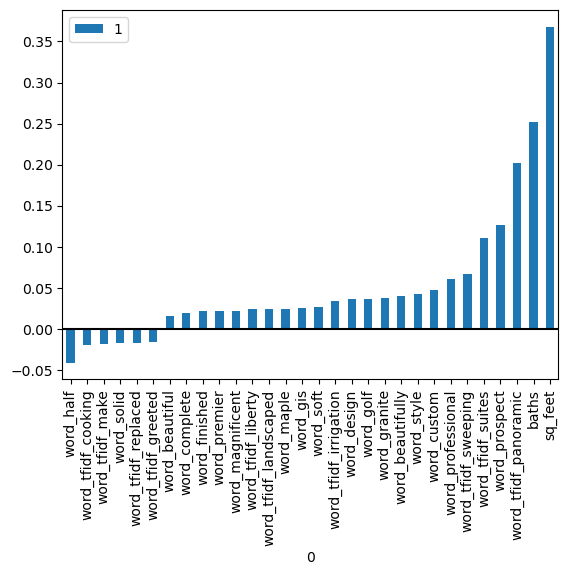

In [162]:
final_coefs[final_coefs['abs_']>.015].sort_values(by=1)[[1]].plot(kind='bar')
plt.axhline(0,color='black',ls='-')